# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
!pip install phik -q

In [2]:
# импорт необходимых библиотек
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy.random import RandomState
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import phik

RANDOM_STATE = 42

### Загрузка данных

In [3]:
# считываем файл geo_data_0.csv и выводим первые пять строк на экран
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
# выводим общую информацию о geo_data_0
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
# считываем файл geo_data_1.csv и выводим первые пять строк на экран
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
# выводим общую информацию о geo_data_1
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
# считываем файл geo_data_2.csv и выводим первые пять строк на экран
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
geo_data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [8]:
# выводим общую информацию о geo_data_1
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Изучив общую информацию о файлах, можем сказать, что всего в таблицах по 100000 строк и 5 столбцов. Во всех таблицах нет пропусков и столбцы имеют верный тип данных. Названия столбцов соответствуют "хорошему" стилю.

### Подготовка данных

Проверим все датасеты на дубликаты.

In [9]:
# создаем список датасетов
datasets = [geo_data_0, geo_data_1, geo_data_2]

# для каждого датасета выводим количество дубликатов
for dataset in datasets:
    display(dataset.duplicated().sum())

0

0

0

In [10]:
geo_data_0 = geo_data_0.drop('id', axis=1)
geo_data_1 = geo_data_1.drop('id', axis=1)
geo_data_2 = geo_data_2.drop('id', axis=1)

Распределения для региона geo_data_0:


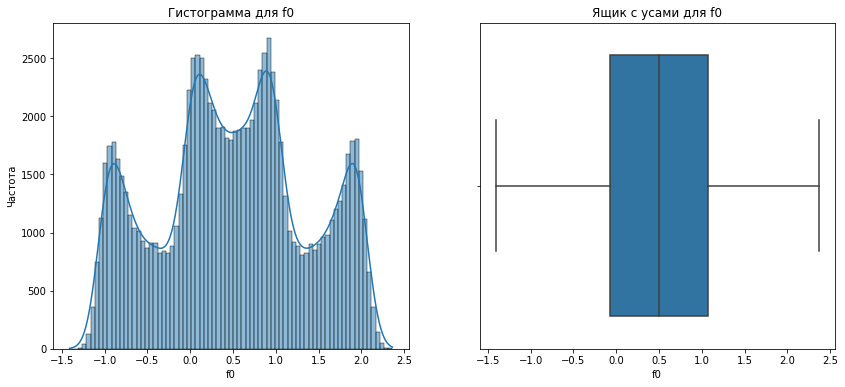

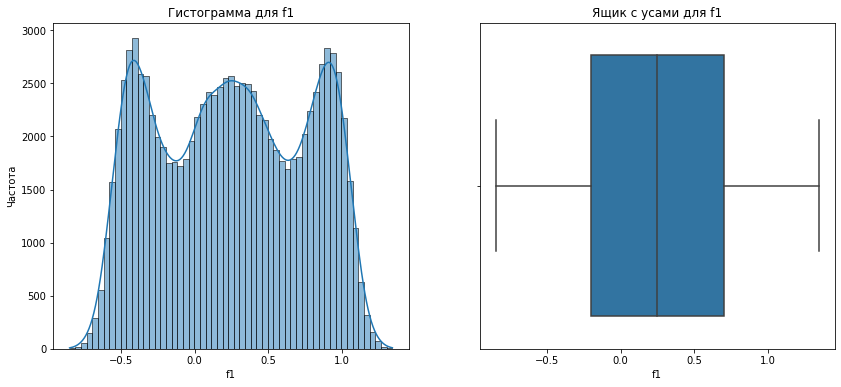

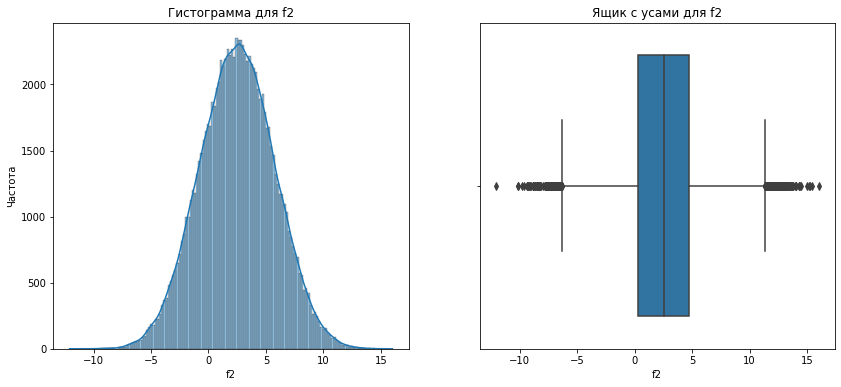

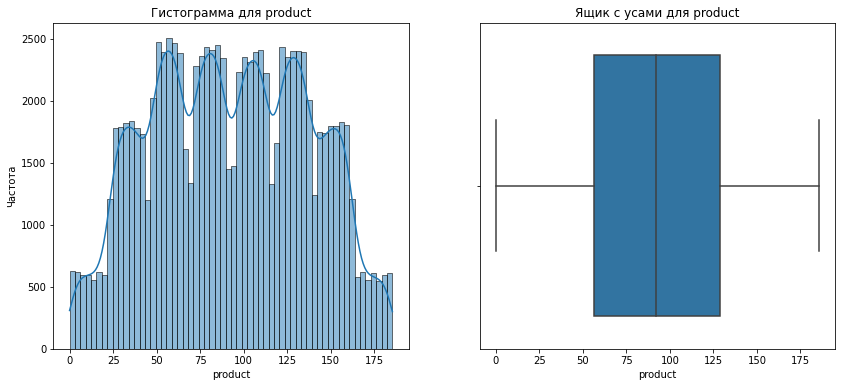

In [11]:
print(f"Распределения для региона geo_data_0:")
for col in geo_data_0.columns:
    plt.figure(figsize=(14,6))

    plt.subplot(1, 2, 1)
    sns.histplot(geo_data_0[col], kde=True)
    plt.title(f'Гистограмма для {col}')
    plt.xlabel(col)  
    plt.ylabel('Частота')  

    plt.subplot(1, 2, 2)
    sns.boxplot(x=geo_data_0[col])
    plt.title(f'Ящик с усами для {col}')
    plt.xlabel(col)  


    plt.show()

In [12]:
corr_0 = geo_data_0.phik_matrix(interval_cols=['f0','f1','f2','product'])
corr_0

,f0,f1,f2,product
f0,1.000000,0.762170,0.000000,0.215525
f1,0.762170,1.000000,0.000000,0.253544
f2,0.000000,0.000000,1.000000,0.475901
product,0.215525,0.253544,0.475901,1.000000


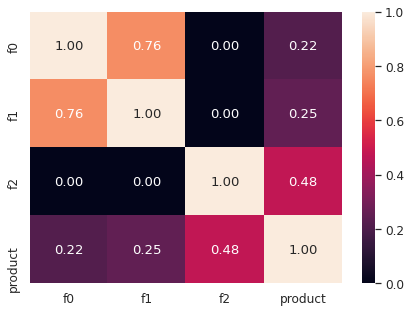

In [13]:
# построим тепловую карту коэффициентов phik
sns.set(font_scale=1.1)
plt.figure(figsize=(7,5))
sns.heatmap(corr_0, annot=True, fmt='.2f') 
plt.show()

Гистограммы распределений входных признаков f0 и f1 и целевого признака не похожи на нормальные распределения, ящики с усами для этих признаков не имеею аномалий и выбросов. Признак f2 распределен нормально, есть много выбросов. 

Анализируя тепловую карту, можем сказать, что есть сильная связь между признаками f0 и f1, коэффициет корреляции phik равен 0,76, а так же есть умеренная связь между входным признаком f2 и целевым, коээфициент корреляции равен 0,48. Мультиколлинеарности нет.

Распределения для региона geo_data_1:


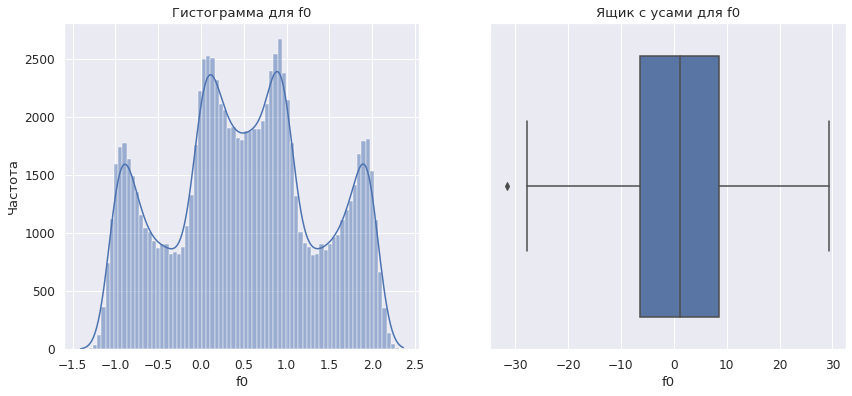

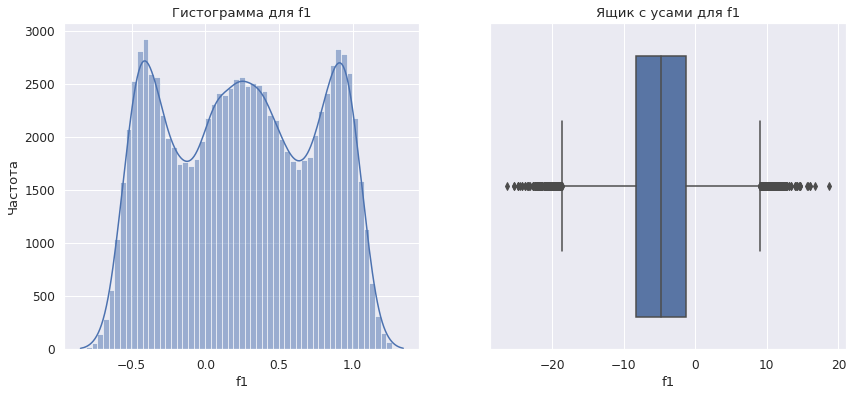

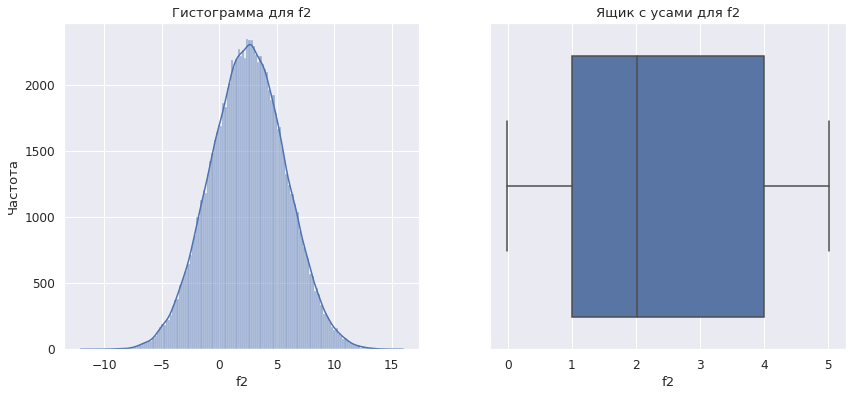

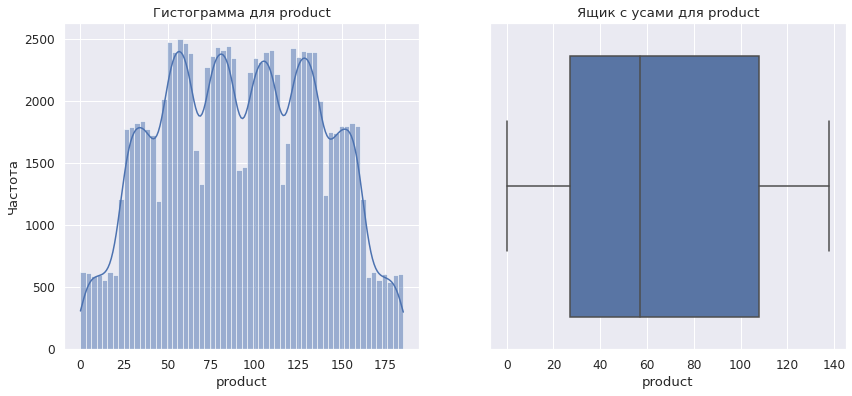

In [14]:
print(f"Распределения для региона geo_data_1:")
for col in geo_data_1.columns:
    plt.figure(figsize=(14,6))

    plt.subplot(1, 2, 1)
    sns.histplot(geo_data_0[col], kde=True)
    plt.title(f'Гистограмма для {col}')
    plt.xlabel(col)  
    plt.ylabel('Частота')  

    plt.subplot(1, 2, 2)
    sns.boxplot(x=geo_data_1[col])
    plt.title(f'Ящик с усами для {col}')
    plt.xlabel(col)  


    plt.show()

In [15]:
corr_1 = geo_data_1.phik_matrix(interval_cols=['f0','f1','f2','product'])
corr_1

,f0,f1,f2,product
f0,1.000000,0.196080,0.000000,0.628482
f1,0.196080,1.000000,0.000000,0.185965
f2,0.000000,0.000000,1.000000,0.978936
product,0.628482,0.185965,0.978936,1.000000


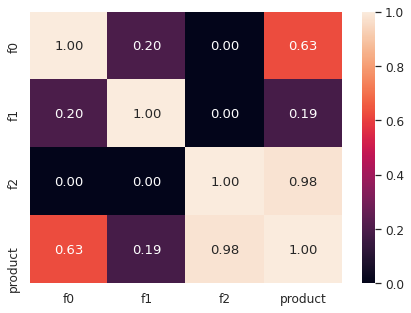

In [16]:
# построим тепловую карту коэффициентов phik
sns.set(font_scale=1.1)
plt.figure(figsize=(7,5))
sns.heatmap(corr_1, annot=True, fmt='.2f') 
plt.show()

Так же как и для региона geo_data_0 гистограммы распределений входных признаков f0 и f1 и целевого признака не похожи на нормальные распределения, ящики с усами для этих признаков не имеею аномалий и выбросов. Признак f2 распределен нормально, есть много выбросов. 

Анализируя тепловую карту, можем сказать, что есть заметная связь между  входным признаком f0 и целевым признаком, коэффициет корреляции phik равен 0,63, а так же есть очень сильная связь между входным признаком f2 и целевым, коээфициент корреляции равен 0,98, что говорит о мультиколлинеарности между этими признаками.

Распределения для региона geo_data_2:


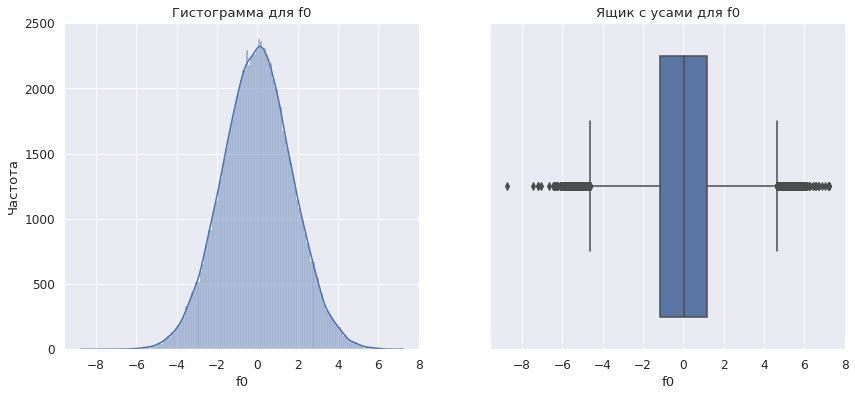

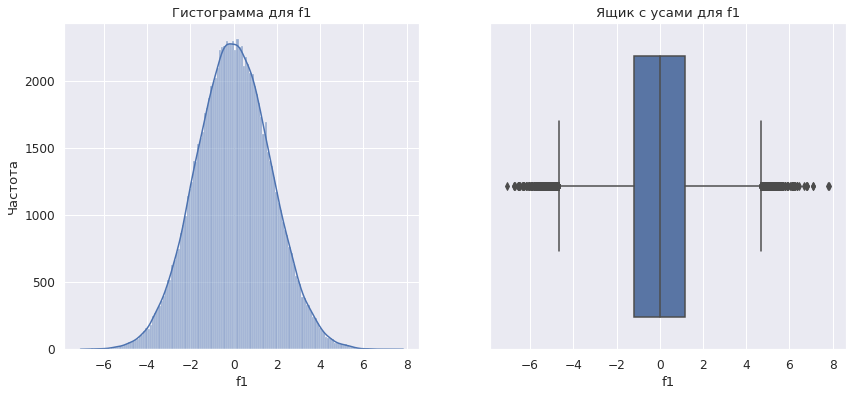

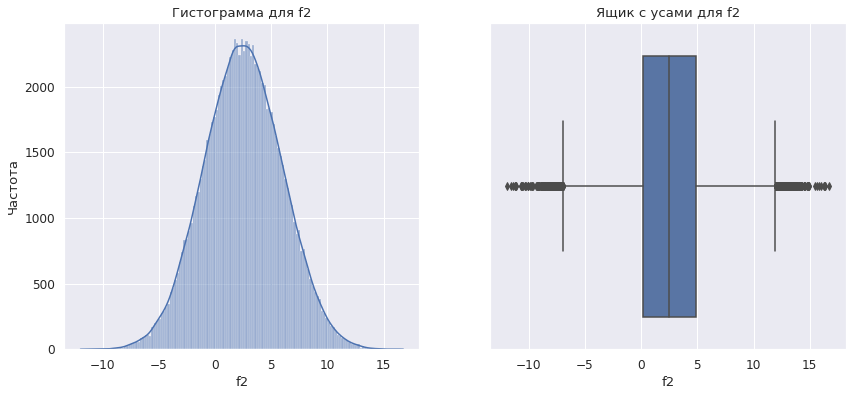

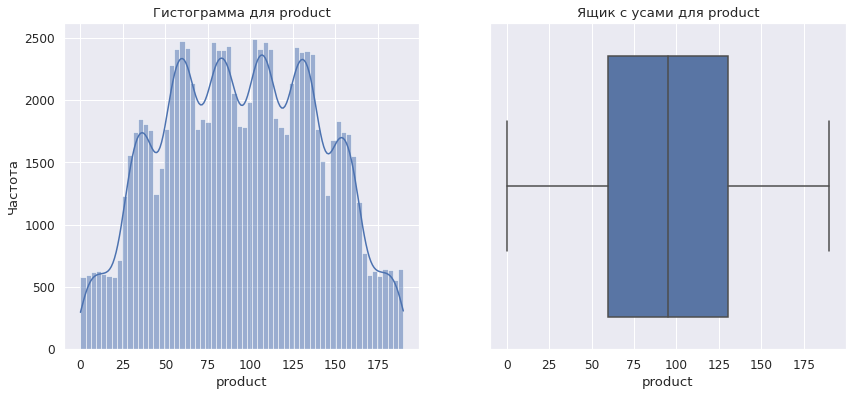

In [17]:
print(f"Распределения для региона geo_data_2:")
for col in geo_data_2.columns:
    plt.figure(figsize=(14,6))

    plt.subplot(1, 2, 1)
    sns.histplot(geo_data_2[col], kde=True)
    plt.title(f'Гистограмма для {col}')
    plt.xlabel(col)  
    plt.ylabel('Частота')  

    plt.subplot(1, 2, 2)
    sns.boxplot(x=geo_data_2[col])
    plt.title(f'Ящик с усами для {col}')
    plt.xlabel(col)  


    plt.show()

In [18]:
corr_2 = geo_data_2.phik_matrix(interval_cols=['f0','f1','f2','product'])
corr_2

,f0,f1,f2,product
f0,1.000000,0.000000,0.000000,0.201068
f1,0.000000,1.000000,0.000000,0.221022
f2,0.000000,0.000000,1.000000,0.443287
product,0.201068,0.221022,0.443287,1.000000


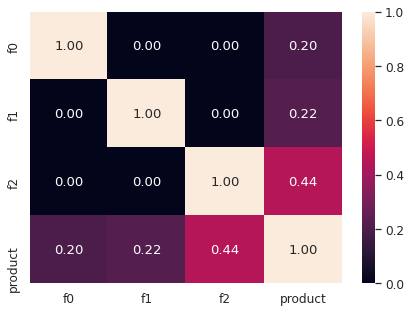

In [19]:
# построим тепловую карту коэффициентов phik
sns.set(font_scale=1.1)
plt.figure(figsize=(7,5))
sns.heatmap(corr_2, annot=True, fmt='.2f') 
plt.show()

В отличие о первых двух регионов, у региона geo_data_2 гистограммы распределений всех входных признаков  похожи на нормальные распределения, все ящики с усами для этих признаков имеют выбросы. Целевой признак на нормальное распределение не похож, выбров нет. 

Анализируя тепловую карту, можем сказать, что есть умеренная связь между  входным признаком f2 и целевым признаком, коэффициет корреляции phik равен 0,44, между остальными признаками связь или слабая или ее нет. Мультиколлинеарности тоже нет.

Разделим датафреймы на обучающие и валидационные выборки в соотношении 75:25.

In [20]:
# определяем признаки и целевое значение для датафрейма geo_data_0
X_0 = geo_data_0.drop('product', axis=1)
y_0 = geo_data_0['product']

# разделение на обучающую и валидационную выборки
X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(
    X_0, 
    y_0,
    test_size=0.25,
    random_state=RANDOM_STATE
)  

# определяем признаки и целевое значение для датафрейма geo_data_1
X_1 = geo_data_1.drop({'product'}, axis=1)
y_1 = geo_data_1['product']

# разделение на обучающую и валидационную выборки
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(
    X_1, 
    y_1,
    test_size=0.25,
    random_state=RANDOM_STATE
) 

# определяем признаки и целевое значение для датафрейма geo_data_1
X_2 = geo_data_2.drop('product', axis=1)
y_2 = geo_data_2['product']

# разделение на обучающую и валидационную выборки
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(
    X_2, 
    y_2,
    test_size=0.25,
    random_state=RANDOM_STATE
) 

Отмасштабируем количественные признаки с помощью StandardScaler.

In [21]:
# список количественных признаков
num_col_names = ['f0', 'f1', 'f2']

# создаем переменную с экземпляром класса StandardScaler()
scaler = StandardScaler()

# создаём тренировочный и валидационный датафреймы из отмасштабированных данных geo_data_0
X_train_0_scaled = pd.DataFrame(scaler.fit_transform(X_train_0[num_col_names]), columns=num_col_names) 
X_valid_0_scaled = pd.DataFrame(scaler.transform(X_valid_0[num_col_names]), columns=num_col_names) 
 
# создаём тренировочный и валидационный датафреймы из отмасштабированных данных geo_data_1
X_train_1_scaled = pd.DataFrame(scaler.fit_transform(X_train_1[num_col_names]), columns=num_col_names) 
X_valid_1_scaled = pd.DataFrame(scaler.transform(X_valid_1[num_col_names]), columns=num_col_names) 
 
# создаём тренировочный и валидационный датафреймы из отмасштабированных данных geo_data_2
X_train_2_scaled = pd.DataFrame(scaler.fit_transform(X_train_2[num_col_names]), columns=num_col_names) 
X_valid_2_scaled = pd.DataFrame(scaler.transform(X_valid_2[num_col_names]), columns=num_col_names) 

## Обучение и проверка модели

In [22]:
# обучение модели и получение предсказаний на валидационных данных
model_lr  = LinearRegression()

# geo_data_0
model_lr.fit(X_train_0, y_train_0)
pred_0 = model_lr.predict(X_valid_0)

# geo_data_1
model_lr.fit(X_train_1, y_train_1)
pred_1 = model_lr.predict(X_valid_1)

# geo_data_2
model_lr.fit(X_train_2, y_train_2)
pred_2 = model_lr.predict(X_valid_2)

Сохраним предсказания и правильные ответы на валидационной выборке для каждого региона. Найдем средний запас предсказанного сырья и RMSE модели. Так же найдем метрику МАЕ для всех регионов.

In [23]:
# объединение входных и целевого признаков валидационной выборки для geo_data_0
# добавление столца с предсказанием в валидационную выборку
valid_geo_data_0 = pd.concat([X_valid_0, y_valid_0], axis=1)
valid_geo_data_0['prediction'] = pred_0
print(f"\nПервые 5 строк из валидационной выборки для региона geo_data_0:")
display(valid_geo_data_0.head())

# найдем средний запас предсказанного сырья для региона geo_data_0
avg_pred_0 = valid_geo_data_0['prediction'].mean()
print(f"\nСредний запас предсказанного сырья для региона geo_data_0: {avg_pred_0}")

# найдем метрику RMSE модели для региона geo_data_0
rmse_0 = mean_squared_error(y_valid_0, pred_0, squared=False) 
print(f"RMSE модели для региона geo_data_0: {rmse_0}")

# найдем метрику МАЕ модели для региона geo_data_0
mae_0 = mean_absolute_error(y_valid_0, pred_0)
print(f"МАЕ модели для региона geo_data_0: {mae_0}")


Первые 5 строк из валидационной выборки для региона geo_data_0:


,f0,f1,f2,product,prediction
75721,0.599283,-0.557623,2.121187,122.073350,101.901017
80184,0.739017,-0.463156,-1.347584,48.738540,78.217774
19864,1.422743,-0.534917,3.718798,131.338088,115.266901
76699,1.580244,-0.238458,2.805149,88.327757,105.618618
92991,0.918974,0.023961,2.598575,36.959266,97.980185



Средний запас предсказанного сырья для региона geo_data_0: 92.39879990657768
RMSE модели для региона geo_data_0: 37.75660035026169
МАЕ модели для региона geo_data_0: 31.047681538788183


In [24]:
# объединение входных и целевого признаков валидационной выборки для geo_data_1
# добавление столца с предсказанием в валидационную выборку
valid_geo_data_1 = pd.concat([X_valid_1, y_valid_1], axis=1)
valid_geo_data_1['prediction'] = pred_1
print(f"\nПервые 5 строк из валидационной выборки для региона geo_data_1:")
display(valid_geo_data_1.head())

# найдем средний запас предсказанного сырья для региона geo_data_1
avg_pred_1 = valid_geo_data_1['prediction'].mean()
print(f"\nСредний запас предсказанного сырья для региона geo_data_1: {avg_pred_1}")

# найдем метрику RMSE модели для региона geo_data_1
rmse_1 = mean_squared_error(y_valid_1, pred_1, squared=False) 
print(f"RMSE модели для региона geo_data_1: {rmse_1}")

# найдем метрику МАЕ модели для региона geo_data_1
mae_1 = mean_absolute_error(y_valid_1, pred_1)
print(f"МАЕ модели для региона geo_data_1: {mae_1}")


Первые 5 строк из валидационной выборки для региона geo_data_1:


,f0,f1,f2,product,prediction
75721,6.078076,0.084568,0.002957,0.000000,0.844738
80184,16.462386,2.712946,1.993030,53.906522,52.921612
19864,7.051898,0.766983,4.990194,134.766305,135.110385
76699,-0.240045,-0.380804,3.999693,107.813044,109.494863
92991,13.350111,-8.558281,0.002010,0.000000,-0.047292



Средний запас предсказанного сырья для региона geo_data_1: 68.71287803913762
RMSE модели для региона geo_data_1: 0.890280100102884
МАЕ модели для региона geo_data_1: 0.7170119535682554


In [25]:
# объединение входных и целевого признаков валидационной выборки для geo_data_2
# добавление столца с предсказанием в валидационную выборку
valid_geo_data_2 = pd.concat([X_valid_2, y_valid_2], axis=1)
valid_geo_data_2['prediction'] = pred_2
print(f"\nПервые 5 строк из валидационной выборки для региона geo_data_2:")
display(valid_geo_data_2.head())

# найдем средний запас предсказанного сырья для региона geo_data_2
avg_pred_2 = valid_geo_data_2['prediction'].mean()
print(f"\nСредний запас предсказанного сырья для региона geo_data_2: {avg_pred_2}")

# найдем метрику RMSE модели для региона geo_data_2
rmse_2 = mean_squared_error(y_valid_2, pred_2, squared=False) 
print(f"RMSE модели для региона geo_data_2: {rmse_2}")

# найдем метрику МАЕ модели для региона geo_data_2
mae_2 = mean_absolute_error(y_valid_2, pred_2)
print(f"МАЕ модели для региона geo_data_2: {mae_2}")


Первые 5 строк из валидационной выборки для региона geo_data_2:


,f0,f1,f2,product,prediction
75721,2.111118,-1.679773,3.112240,117.441301,98.301916
80184,0.734759,0.747788,3.670879,47.841249,101.592461
19864,-2.513109,0.844631,-4.922889,45.883483,52.449099
76699,-2.035301,-1.522988,5.072839,139.014608,109.922127
92991,2.744145,1.429952,-1.372661,84.004276,72.411847



Средний запас предсказанного сырья для региона geo_data_2: 94.77102387765939
RMSE модели для региона geo_data_2: 40.145872311342174
МАЕ модели для региона geo_data_2: 32.896958610578054


Данные результаты показывают, что модели имеют различное качество предсказаний для разных наборов данных. Модель для geo_data_1 имеет наименьшие значения RMSE (0,89) и MAE (0,72), что указывает на лучшую точность предсказаний по сравнению с другими моделями. Модель для geo_data_2 имеет наибольшие значения RMSE (40,15) и МАЕ (32,9), что указывает на наибольшую ошибку предсказаний.

## Подготовка к расчёту прибыли

 Все ключевые значения для расчётов сохраним в отдельных переменных.

In [26]:
# бюджет на разработку скважин в регионе
BUDZET = 10000000000

# доход с каждой единицы продукта
REVENUE_PER_UNIT = 450000

# количество исследуемых скважин
WELLS_STUDY = 500

# количество лучших скважин
WELLS_BEST = 200

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [27]:
# достаточный объём сырья для безубыточной разработки новой скважины
BEZUB_VOL = BUDZET / (REVENUE_PER_UNIT * WELLS_BEST)
BEZUB_VOL

111.11111111111111

Достаточный объём сырья для безубыточной разработки новой скважины 111 тысяч баррелей, но ни в одном регионе по предсказанию модели нет достаточного объема сырья, в регионе geo_data_0 предсказанный объем сырья равен 92 тысячи баррелей, в регионе geo_data_1 - 69 тысяч баррелей, а в регионе geo_data_2 - 95 тысяч баррелей. Можем сделать вывод, что с точки зрения безубыточности, ни один из регионов не достигает необходимого уровня запасов сырья.

In [28]:
# найдем средний запас целевой переменной для региона geo_data_0
avg_0 = valid_geo_data_0['product'].mean()
print(f"\nСредний запас целевой переменной для региона geo_data_0: {avg_0}")
# найдем средний запас целевой переменной для региона geo_data_1
avg_1 = valid_geo_data_1['product'].mean()
print(f"\nСредний запас целевой переменной для региона geo_data_1: {avg_1}")
# найдем средний запас целевой переменной для региона geo_data_2
avg_2 = valid_geo_data_2['product'].mean()
print(f"\nСредний запас целевой переменной для региона geo_data_2: {avg_2}")


Средний запас целевой переменной для региона geo_data_0: 92.32595637084387

Средний запас целевой переменной для региона geo_data_1: 68.72538074722745

Средний запас целевой переменной для региона geo_data_2: 95.15099907171961


Средний запас целевой переменной почти полностью совпадает со средним запасом предсказанной переменной, что так же недостаточно для безуыточной разработки новой скважины.

In [29]:
# сортируем данные по предсказанному объему сырья и выбираем 200 лучших скважин
top_wells_0 = valid_geo_data_0.sort_values('prediction', ascending=False).head(200)
top_wells_1 = valid_geo_data_1.sort_values('prediction', ascending=False).head(200)
top_wells_2 = valid_geo_data_2.sort_values('prediction', ascending=False).head(200)

# найдем средний запас предсказанного сырья 200 лучших скважин
avg_top_0 = top_wells_0['product'].mean()
print(f"\nСредний запас сырья 200 лучших скважин для региона geo_data_0: {avg_top_0}")

avg_top_1 = top_wells_1['product'].mean()
print(f"\nСредний запас сырья 200 лучших скважин для региона geo_data_1: {avg_top_1}")

avg_top_2 = top_wells_2['product'].mean()
print(f"\nСредний запас сырья 200 лучших скважин для региона geo_data_2: {avg_top_2}")


Средний запас сырья 200 лучших скважин для региона geo_data_0: 148.434901271802

Средний запас сырья 200 лучших скважин для региона geo_data_1: 137.9454077409057

Средний запас сырья 200 лучших скважин для региона geo_data_2: 139.98413065971235


Картина меняется, если мы берем средний запас сырья только двухста предсказанных лучших скважин в каждом регионе. Теперь все регионы подходят для безубыточной разработки скважины.

## Расчёт прибыли и рисков 

Создадим функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [30]:
state = RandomState(123)

def profit_calculation(data):
        # выбираем лучшие скважины с максимальными значениями предсказаний
        wells_special = data.sort_values(by='prediction', ascending=False).head(WELLS_BEST)
        # просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям
        volume_best = wells_special['product'].sum()
        # рассчитываем прибыль для полученного объёма сырья
        profit = volume_best * REVENUE_PER_UNIT - BUDZET
        return profit

# рассчитаем прибыль с полученного сырья для региона geo_data_0
profit_0 = profit_calculation(valid_geo_data_0)
print(f"\nПрибыль с полученного сырья 200 лучших скважин для региона geo_data_0: {profit_0}")

# рассчитаем прибыль с полученного сырья для региона geo_data_1
profit_1 = profit_calculation(valid_geo_data_1)
print(f"\nПрибыль с полученного сырья 200 лучших скважин для региона geo_data_1: {profit_1}")

# рассчитаем прибыль с полученного сырья для региона geo_data_2
profit_2 = profit_calculation(valid_geo_data_2)
print(f"\nПрибыль с полученного сырья 200 лучших скважин для региона geo_data_2: {profit_2}")


Прибыль с полученного сырья 200 лучших скважин для региона geo_data_0: 3359141114.462179

Прибыль с полученного сырья 200 лучших скважин для региона geo_data_1: 2415086696.681511

Прибыль с полученного сырья 200 лучших скважин для региона geo_data_2: 2598571759.374111


Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [31]:
def bootstrap(data):
        values = []
        for i in range(1000):
            subsample = data.sample(n=500, replace=True, random_state=state)
            profit = profit_calculation(subsample)
            values.append(profit)
        values = pd.Series(values)
        mean_profit = values.mean()
        lower = values.quantile(0.025)
        upper = values.quantile(0.975)
        risk = (values < 0).mean()
        return mean_profit, lower, upper, risk
    
mean_profit_0, lower_0, upper_0, risk_0 = bootstrap(valid_geo_data_0)
print(f"\nВывод прибыли и рисков для региона geo_data_0:")
print(f"Средняя прибыль: {mean_profit_0}")
print(f"95%-й доверительный интервал (нижняя граница): {lower_0}")
print(f"95%-й доверительный интервал (верхняя граница): {upper_0}")
print(f"Риск убытков: {risk_0}")

mean_profit_1, lower_1, upper_1, risk_1 = bootstrap(valid_geo_data_1)
print(f"\nВывод прибыли и рисков для региона geo_data_1:")
print(f"Средняя прибыль: {mean_profit_1}")
print(f"95%-й доверительный интервал (нижняя граница): {lower_1}")
print(f"95%-й доверительный интервал (верхняя граница): {upper_1}")
print(f"Риск убытков: {risk_1}")

mean_profit_2, lower_2, upper_2, risk_2 = bootstrap(valid_geo_data_2)
print(f"\nВывод прибыли и рисков для региона geo_data_2:")
print(f"Средняя прибыль: {mean_profit_2}")
print(f"95%-й доверительный интервал (нижняя граница): {lower_2}")
print(f"95%-й доверительный интервал (верхняя граница): {upper_2}")
print(f"Риск убытков: {risk_2}")


Вывод прибыли и рисков для региона geo_data_0:
Средняя прибыль: 401769373.69071746
95%-й доверительный интервал (нижняя граница): -125162909.03105578
95%-й доверительный интервал (верхняя граница): 904713873.3711025
Риск убытков: 0.064

Вывод прибыли и рисков для региона geo_data_1:
Средняя прибыль: 448808590.59852433
95%-й доверительный интервал (нижняя граница): 71768627.60362038
95%-й доверительный интервал (верхняя граница): 860162397.7469591
Риск убытков: 0.011

Вывод прибыли и рисков для региона geo_data_2:
Средняя прибыль: 376166422.2955545
95%-й доверительный интервал (нижняя граница): -131499425.48209594
95%-й доверительный интервал (верхняя граница): 886768344.9588202
Риск убытков: 0.085


На основании проведенного анализа, регион geo_data_1 является предпочтительным для разработки скважин. 

Во-первых, в этом регионе риск убытков меньше всего, составляет всего 0,011 или 1,1 %.

Во-вторых, в этом регионе самая высокая средняя прибыль - 448808590 руб.

И в-третьих, 95%-й доверительный интервал составляет от 71768628 до 860162398, что указывает на стабильность и надежность прогнозируемой прибыли.

В данной  работе нужно было решить, где бурить новую скважину добывающей компании «ГлавРосГосНефть».

Нам были предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.

Мы провели загрузку, исследовательский и корреляционный анализ данных во всех трех регионах, а так же  подготовили данные к обучению. Так же мы построили модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировали возможную прибыль и риски техникой Bootstrap.

На основании проведенного анализа, мы предполагаем, что регион geo_data_1 является наиболее предпочтительным для разработки скважин. В этом регионе риск убытков меньше всего, составляет всего 0,011 или 1,1 %., так же в этом регионе самая высокая средняя прибыль - 448808590 руб и 95%-й доверительный интервал составляет от 71768628 до 860162398, что указывает на стабильность и надежность прогнозируемой прибыли.